<a href="https://colab.research.google.com/github/mhou426/Solving-a-Maze-Using-a-Goal-based-Agent/blob/main/Copy_of_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


All student names in group: John Bilello, Mingrong Hou, Jordan Cassella

I understand that my submission needs to be my own group's work: [JC, JB, MH]

I understand that ChatGPT / Copilot / other AI tools are not allowed: [JC, JB, MH]

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [ ]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

Cloning into 'CS7320-AI'...
remote: Enumerating objects: 2637, done.
remote: Counting objects: 100% (754/754), done.
remote: Compressing objects: 100% (313/313), done.
remote: Total 2637 (delta 466), reused 712 (delta 436), pack-reused 1883
Receiving objects: 100% (2637/2637), 283.93 MiB | 23.45 MiB/s, done.
Resolving deltas: 100% (1634/1634), done.
/content/CS7320-AI/Search/CS7320-AI/Search
empty_2_maze.txt	  loops_maze.txt		     maze_helper.py   small_maze.txt
empty_maze.txt		  Maze_BFS_vs_A_Star.ipynb	     Maze.ipynb       wall_maze.txt
Explore_heuristics.ipynb  Maze_Example-Animation_full.ipynb  medium_maze.txt
large_maze.txt		  Maze_Example-Animation.ipynb	     open_maze.txt
L_maze.txt		  Maze_Example.ipynb		     README.md


In [ ]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [ ]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

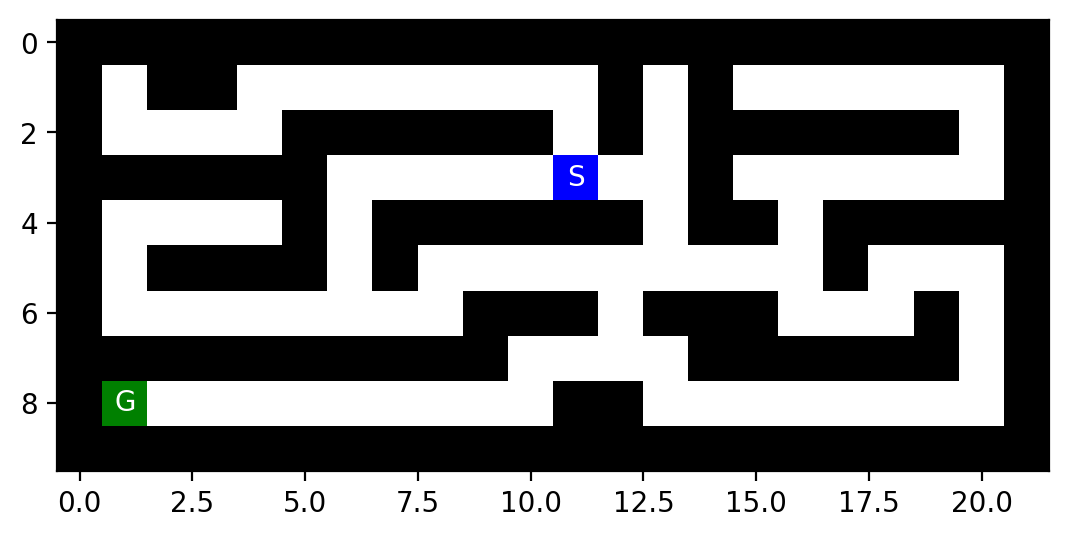

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [ ]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [ ]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /content/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [ ]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"

    #needed for priority queue
    def __lt__(self, other):
        return self.cost < other.cost

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

In [ ]:
# Initial State: The agent located at the start position, the configuration of walls.
# Actions: The moves that the agent makes (up, down, left, right).
# Transition Model: Moves the agent in the maze. Ensures move is valid (agent can't move into wall).
# Goal State: The agent located at the destination position.
# Path Cost: Cost of 1 for each action until goal is reached.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

In [ ]:
# n: Create a variable "num_states". Each time an element is appended to the frontier, increase the count.
# d: By assigning each frontier space a "Node" as defined earlier, a path to the starting (root) node can be traced from the goal node.
# m: Create a variable "max_depth". Each time a node is created, see if it is deeper. If so, update "max_depth" to be the new depth.
# b: Create a variable "max_branch". Each time the frontier is expanded, check if its number of elements is greater. If, so update "max_branch" to be the number of elements in the frontier.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DSF can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DSF is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.

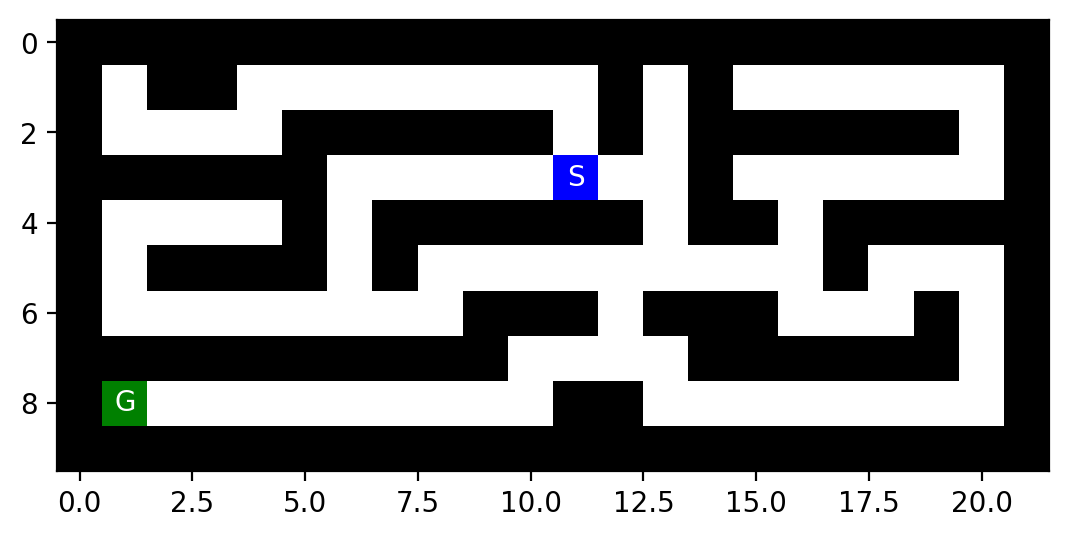

(20, 92, 20, 95, 9)

In [ ]:
# Your code goes here
import maze_helper as mh
maze = mh.parse_maze(maze_str)
from queue import Queue

# BFS
def BFS(maze, max_steps = 10000):
  initial = mh.find_pos(maze, what = "S") #pos
  final = mh.find_pos(maze, what = "G")

  rootNode = Node(initial, None, None, 1)
  visited = []

  #statistics
  num_nodes = 1 #get updated for each for iteration, adding to visited
  max_depth = 1
  max_memory = 1
  max_frontier = 1
  num_steps = 0 #get updated for each while iteration
  dest_node = None
  queue = Queue() #frontier

  if initial == final:
    dest_node = initial
    return (1, num_nodes, max_depth, max_frontier, max_frontier)

  queue.put(rootNode)
  visited.append(initial) #store pos, reached

  while not queue.empty():#not empty
    num_steps += 1
    if(num_steps == max_steps):
      return (-1, num_nodes, max_depth, max_memory, max_frontier)
    rootNode = queue.get()

    #create neighbours nodes
    neighbours = []
    if (maze[rootNode.pos[0] + 1][rootNode.pos[1]] == " "):
      neighbours.append(Node((rootNode.pos[0] + 1,rootNode.pos[1]), rootNode, "down", rootNode.cost+1))
    if (maze[rootNode.pos[0] - 1][rootNode.pos[1]] == " "):
      neighbours.append(Node((rootNode.pos[0] - 1,rootNode.pos[1]), rootNode, "up", rootNode.cost+1))
    if (maze[rootNode.pos[0]][rootNode.pos[1] + 1] == " "):
      neighbours.append(Node((rootNode.pos[0],rootNode.pos[1] + 1), rootNode, "right", rootNode.cost+1))
    if (maze[rootNode.pos[0]][rootNode.pos[1] - 1] == " "):
      neighbours.append(Node((rootNode.pos[0],rootNode.pos[1] - 1), rootNode, "left", rootNode.cost+1))

    #search for G from neighbours
    if(maze[rootNode.pos[0] + 1][rootNode.pos[1]] == "G"):
      dest_node = Node((rootNode.pos[0] + 1,rootNode.pos[1]), rootNode, "down", rootNode.cost+1)
      break
    if(maze[rootNode.pos[0] - 1][rootNode.pos[1]] == "G"):
      dest_node = Node((rootNode.pos[0] - 1,rootNode.pos[1]), rootNode, "up", rootNode.cost+1)
      break
    if(maze[rootNode.pos[0]][rootNode.pos[1] + 1] == "G"):
      dest_node = Node((rootNode.pos[0],rootNode.pos[1] + 1), rootNode, "right", rootNode.cost+1)
      break
    if(maze[rootNode.pos[0]][rootNode.pos[1] - 1] == "G"):
      dest_node = Node((rootNode.pos[0],rootNode.pos[1] - 1), rootNode, "left", rootNode.cost+1)
      break

    #for each child check for G, if not visited, put in queue and update stats
    for child in neighbours:
      s = child.pos

      if s == final:
        dest_node = child
        break

      if s not in visited:
        queue.put(child)
        visited.append(s)
        num_nodes += 1
        if(queue.qsize() > max_frontier): max_frontier = queue.qsize()
        if(queue.qsize() + len(visited) > max_memory): max_memory = queue.qsize() + len(visited)
        if(child.cost > max_depth): max_depth = child.cost

  if dest_node:
    if (dest_node.cost > max_depth):
      max_depth = dest_node.cost
      num_nodes += 1
    return(len(dest_node.get_path_from_root()), num_nodes, max_depth, max_memory, max_frontier)
  else:
    return (-1, num_nodes, max_depth, max_memory, max_frontier)

# DFS
def DFS(maze, max_steps = 10000):
  start_pos = mh.find_pos(maze, what = "S")
  end_pos = mh.find_pos(maze, what = "G")

  root = Node(start_pos, None, None, 1)
  stack = [root]

  #statistics
  num_nodes = 1
  max_depth = 1
  max_frontier = 1
  num_steps = 0

  dest_node = None

  while stack:
    num_steps += 1
    if(num_steps == max_steps): return (-1, num_nodes, max_depth, max_frontier, max_frontier)

    node = stack.pop()

    childs = []

    # Iterate through adjacencies
    if(maze[node.pos[0] + 1][node.pos[1]] == " "):
      childs.append(Node((node.pos[0] + 1,node.pos[1]), node, None, node.cost+1))
    if(maze[node.pos[0] - 1][node.pos[1]] == " "):
      childs.append(Node((node.pos[0] - 1,node.pos[1]), node, None, node.cost+1))
    if(maze[node.pos[0]][node.pos[1] + 1] == " "):
      childs.append(Node((node.pos[0],node.pos[1] + 1), node, None, node.cost+1))
    if(maze[node.pos[0]][node.pos[1] - 1] == " "):
      childs.append(Node((node.pos[0],node.pos[1] - 1), node, None, node.cost+1))

    # Search for goal
    if(maze[node.pos[0] + 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] + 1,node.pos[1]), node, None, node.cost+1)
      break
    if(maze[node.pos[0] - 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] - 1,node.pos[1]), node, None, node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] + 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] + 1), node, None, node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] - 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] - 1), node, None, node.cost+1)
      break

    for child in childs:
      append = True
      # Avoid duplicates in frontier. In theory complexity O(n) in practice frontier is much smaller.
      for element in stack:
        if(child.pos == element.pos):
          append = False #No duplicates in frontier
          break
      # Prevent infinite loops
      if(node.parent != None and child.pos == node.parent.pos):
        append = False

      # Append to frontier
      if(append):
        stack.append(child)
        # Update Stats
        num_nodes += 1
        if(len(stack) > max_frontier): max_frontier = len(stack)
        if(child.cost > max_depth): max_depth = child.cost


  # Update Stats for Dest
  if(dest_node.cost > max_depth): max_depth = dest_node.cost
  num_nodes += 1

  return(len(dest_node.get_path_from_root()), num_nodes, max_depth, max_frontier, max_frontier)

with open("small_maze.txt", "r") as f:
  maze_str = f.read()

maze = mh.parse_maze(maze_str)
mh.show_maze(maze)
DFS(maze)
BFS(maze)

How does BFS and DFS deal with loops (cycles)?

In [ ]:
# Discussion
# BFS deal with cycle with a "reached" structure. It needs to keep track a list of visited nodes and visit the ones that haven't visited previously.
# DFS fails to deal with cycles without a "reached" structure. It is more likely to loop in open spaces. Preventing duplicates in the "frontier" stack decreases the frequency of loops.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

In [ ]:
# Discussion

# BFS:
# Since it is a systematic search strategy, it is complete even on infinite state spaces.
# Our implementation is optimal only if the costs are all 1.

# Space Complexity: O(n^2) where n is the number of spaces in the maze.
# Time Complexity: O(n^2) where n is the number of spaces in the maze.

# DFS:
# Our implementation is incomplete as it fails to account for open spaces and thus can get into an infinite loop.
# Our implementation is not optimal as DFS can fail to find the shortest path. This is because it searches each branch of the tree down to the leaf regardless of its length.

# Space Complexity: O(n) where n is the number of spaces in the maze.
# Time Complexity (no loops): O(n^2) where n is the number of spaces in the maze. In practice, the time complexity is closer to O(n) as the frontier is usually a small fraction of the overall nodes.

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).

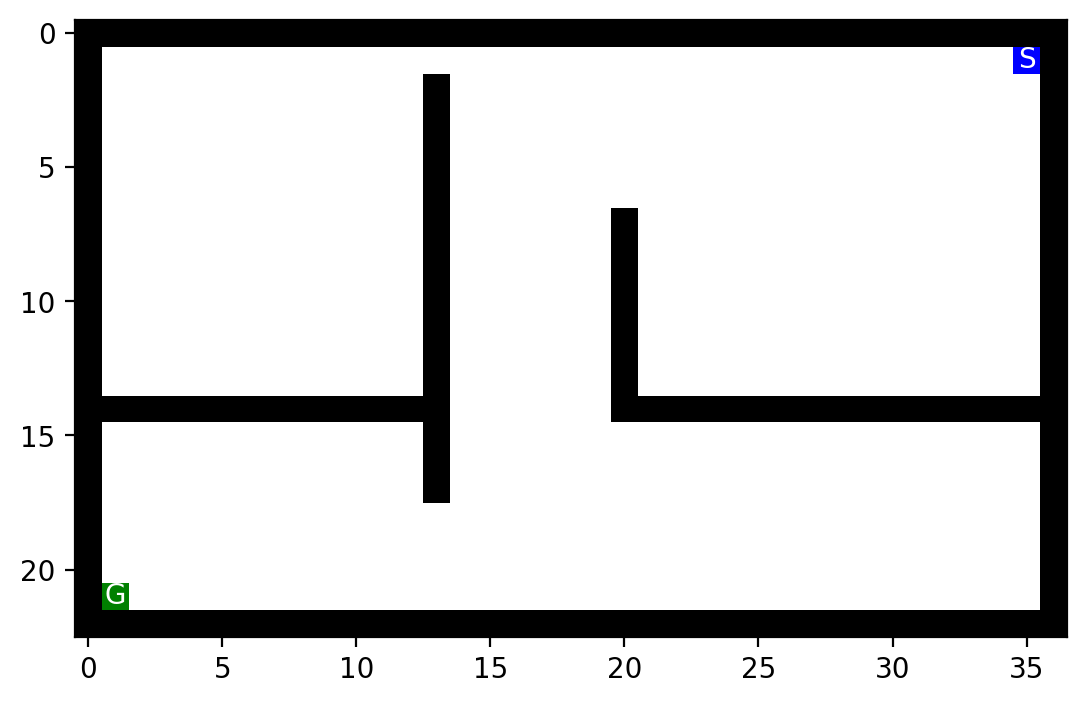

(55, 570, 55, 617, 51)

In [ ]:
# Your code goes here
import math
import queue

def heuristic(pos, dest):
  x1, y1 = pos
  x2, y2 = dest
  return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# Greedy BFS
def greedy_BFS(maze, max_steps = 10000):
  start_pos = mh.find_pos(maze, what = "S")
  end_pos = mh.find_pos(maze, what = "G")

  root = Node(start_pos, None, None, 1)
  frontier = queue.PriorityQueue() # Frontier
  frontier.put((heuristic(start_pos, end_pos), root))
  reached = [root.pos] # Reached

  #statistics
  num_nodes = 1
  max_depth = 1
  max_frontier = 1
  max_memory = 1
  num_steps = 0

  dest_node = None

  while not frontier.empty():
    num_steps += 1
    if(num_steps == max_steps): return (-1, num_nodes, max_depth, max_memory, max_frontier)

    priority, node = frontier.get()

    childs = []

    # Iterate through adjacencies
    if(maze[node.pos[0] + 1][node.pos[1]] == " "):
      childs.append(Node((node.pos[0] + 1,node.pos[1]), node, None, node.cost+1))
    if(maze[node.pos[0] - 1][node.pos[1]] == " "):
      childs.append(Node((node.pos[0] - 1,node.pos[1]), node, None, node.cost+1))
    if(maze[node.pos[0]][node.pos[1] + 1] == " "):
      childs.append(Node((node.pos[0],node.pos[1] + 1), node, None, node.cost+1))
    if(maze[node.pos[0]][node.pos[1] - 1] == " "):
      childs.append(Node((node.pos[0],node.pos[1] - 1), node, None, node.cost+1))

    # Search for goal
    if(maze[node.pos[0] + 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] + 1,node.pos[1]), node, None, node.cost+1)
      break
    if(maze[node.pos[0] - 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] - 1,node.pos[1]), node, None, node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] + 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] + 1), node, None, node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] - 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] - 1), node, None, node.cost+1)
      break


    for child in childs:
      # Append to frontier
      if(not(child.pos in reached)):
        reached.append(child.pos)
        frontier.put((heuristic(child.pos, end_pos), child))
        # Update Stats
        num_nodes += 1
        if(frontier.qsize() > max_frontier): max_frontier = frontier.qsize()
        if(frontier.qsize() + len(reached) > max_memory): max_memory = frontier.qsize() + len(reached)
        if(child.cost > max_depth): max_depth = child.cost

  if(dest_node == None): return (-1, num_nodes, max_depth, max_memory, max_frontier)

  # Update Stats for Dest
  if(dest_node.cost > max_depth): max_depth = dest_node.cost
  num_nodes += 1

  return(len(dest_node.get_path_from_root()), num_nodes, max_depth, max_memory, max_frontier)

# A*
def A_STAR(maze, max_steps = 10000):
  start_pos = mh.find_pos(maze, what = "S")
  end_pos = mh.find_pos(maze, what = "G")

  root = Node(start_pos, None, None, 1)
  frontier = queue.PriorityQueue() # Frontier
  g = root.cost
  h = heuristic(start_pos, end_pos)
  f = g + h
  frontier.put((f, root))
  visited = [root.pos] # Reached

  #statistics
  num_nodes = 1
  max_depth = 1
  max_frontier = 1
  max_memory = 1
  num_steps = 0

  dest_node = None

  if start_pos == end_pos:
    dest_node = start_pos
    return (1, num_nodes, max_depth, max_frontier, max_frontier)

  # Main loop of A* search algorithm
  while not frontier.empty():
    num_steps += 1
    if(num_steps == max_steps): return (-1, num_nodes, max_depth, max_memory, max_frontier)

    priority, node = frontier.get()

    neighbours = []

    # Create a new node for each direction
    if(maze[node.pos[0] + 1][node.pos[1]] == " "):
      neighbours.append(Node((node.pos[0] + 1,node.pos[1]), node, "down", node.cost+1))
    if(maze[node.pos[0] - 1][node.pos[1]] == " "):
      neighbours.append(Node((node.pos[0] - 1,node.pos[1]), node, "up", node.cost+1))
    if(maze[node.pos[0]][node.pos[1] + 1] == " "):
      neighbours.append(Node((node.pos[0],node.pos[1] + 1), node, "right", node.cost+1))
    if(maze[node.pos[0]][node.pos[1] - 1] == " "):
      neighbours.append(Node((node.pos[0],node.pos[1] - 1), node, "left", node.cost+1))

    # Search for goal
    if(maze[node.pos[0] + 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] + 1,node.pos[1]), node, "down", node.cost+1)
      break
    if(maze[node.pos[0] - 1][node.pos[1]] == "G"):
      dest_node = Node((node.pos[0] - 1,node.pos[1]), node, "up", node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] + 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] + 1), node, "right", node.cost+1)
      break
    if(maze[node.pos[0]][node.pos[1] - 1] == "G"):
      dest_node = Node((node.pos[0],node.pos[1] - 1), node, "left", node.cost+1)
      break

    for child in neighbours:
      # Append to frontier
      s = child.pos

      if s == end_pos:
        dest_node = child
        break

      if s not in visited:
        g_new = child.cost
        h_new = heuristic(child.pos, end_pos)
        f_new = g_new + h_new

        visited.append(child.pos)
        frontier.put((f_new, child))
        # Update Stats
        num_nodes += 1
        if(frontier.qsize() > max_frontier): max_frontier = frontier.qsize()
        if(frontier.qsize() + len(visited) > max_memory): max_memory = frontier.qsize() + len(visited)
        if(child.cost > max_depth): max_depth = child.cost

  # If the destination is not found after visiting all nodes
  if(dest_node == None): return (-1, num_nodes, max_depth, max_memory, max_frontier)

  # Update Stats for Dest
  if(dest_node.cost > max_depth): max_depth = dest_node.cost
  num_nodes += 1

  return(len(dest_node.get_path_from_root()), num_nodes, max_depth, max_memory, max_frontier)


with open("open_maze.txt", "r") as f:
  maze_str = f.read()

maze = mh.parse_maze(maze_str)
mh.show_maze(maze)
greedy_BFS(maze)
A_STAR(maze)

Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion

# Greedy BFS
# Our implementation is complete as it is based off BFS and BFS is complete.
# Our implementation is not optimal as the heuristic function can lead the search into a suboptimal dead end. The correct solution may involve moving away from the destination first.

# Space Complexity: O(n) where n is the number of spaces in the maze.
# Time Complexity: O(n) where n is the number of spaces in the maze.

# A*
# Our implementation is complete as it is also based off BFS and BFS is complete.
# Our implementation is optimal because admissible heuristics expand toward the goal while considering the true cost to a nearest goal.

# Space Complexity: O(n) where n is the number of spaces in the maze.
# Time Complexity: O(n) where n is the number of spaces in the maze.

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
import pandas as pd

# Add code
def fill_table(maze_name, search_algos):
  with open(maze_name + ".txt", "r") as f:
    maze_str = f.read()

  maze = mh.parse_maze(maze_str)
  #mh.show_maze(maze)

  results = {}
  for algo_name, algo_function in search_algos.items():


    results[algo_name] = algo_function(maze) #returns 5 tuple

  df = pd.DataFrame.from_dict(results, orient='index', columns=['path cost', '# of nodes expanded', 'max tree depth', 'max # of nodes in memory', 'max frontier size'])
  print("\n\n" + maze_name)
  display(df)

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [ ]:
search_algos = {'BFS': BFS, 'DFS': DFS, 'Greedy BFS' : greedy_BFS, 'A*': A_STAR} # future algos can be added here
maze_names = ("small_maze", "medium_maze", "large_maze", "open_maze", "wall_maze", "loops_maze", "empty_maze", "empty_2_maze")

for maze_name in maze_names:
  fill_table(maze_name, search_algos)



small_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,20,92,20,95,9
DFS,50,78,50,7,7
Greedy BFS,30,44,30,48,5
A*,20,61,20,65,7




medium_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,69,269,69,272,8
DFS,131,153,131,9,9
Greedy BFS,153,167,153,174,8
A*,69,231,69,235,8




large_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,211,620,211,623,8
DFS,211,462,223,37,37
Greedy BFS,211,492,211,512,21
A*,211,566,211,575,10




open_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,55,683,55,687,25
DFS,-1,10090,584,91,91
Greedy BFS,55,116,55,177,62
A*,55,570,55,617,51




wall_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,15,88,15,92,11
DFS,27,51,27,25,25
Greedy BFS,17,42,17,61,20
A*,15,86,15,105,20




loops_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,24,72,24,73,8
DFS,28,40,28,13,13
Greedy BFS,36,61,36,70,10
A*,24,67,24,75,10




empty_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,15,95,15,99,12
DFS,35,73,35,39,39
Greedy BFS,15,31,15,47,17
A*,15,93,15,112,20




empty_2_maze


,path cost,# of nodes expanded,max tree depth,max # of nodes in memory,max frontier size
BFS,15,95,15,99,12
DFS,35,73,35,37,37
Greedy BFS,15,31,15,47,17
A*,15,93,15,112,20


Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion
# Each of the algorithms has their own advantages.
# DFS finds the solution in the cheapest way.
# BFS can always find an optimal solution if the costs are all 1.
# Greedy BFS tends to find a good (but not always optimal) solution quicker than BFS.
# A* Search is designed to find the most optimal solution with the shortest path and optimal cost. With this algorthim, BFS's shortcoming is fixed.

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.